### Superhero Name Generator

---

Import the data

In [49]:
with open('/Users/samfargo/Desktop/superheroes.txt', 'r') as f:
  data = f.read()

data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [50]:
import tensorflow as tf 

Create a tokenizer

In [51]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [52]:
tokenizer.fit_on_texts(data)

Char to index and index to char dictionaries

In [53]:
char_to_index = tokenizer.word_index
index_to_char = dict((v, k) for k, v in char_to_index.items())

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


Convert between names and sequences

In [54]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [55]:
tokenizer.texts_to_sequences(names[0]) # builds functionality to convert sequences of characters to sequences of numbers

[[25], [16], [12], [20], [2], [1]]

In [56]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [57]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [58]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i != 0])

In [59]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

Create sequences

In [60]:
sequences= []

for name in names:
  seq = name_to_seq(name)
  if len(seq) >= 2:
    sequences += [seq[:i] for i in range(2, len(seq) + 1)]

In [61]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [62]:
max_len = max([len(x) for x in sequences])
print(max_len)

33


Pad all sequences

In [63]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding='pre',
    maxlen=max_len
)

print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [64]:
padded_sequences.shape

(88279, 33)

Create training and validation sets

In [65]:
x, y = padded_sequences[:, :-1], padded_sequences[:, -1]
print(x.shape, y.shape)

(88279, 32) (88279,)


In [66]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [67]:
num_chars = len(char_to_index.keys()) + 1
print(num_chars) # A-Z, space, tab, 0

29


Create the model

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM
from tensorflow.keras.layers import Bidirectional, Dense

model = Sequential([
                    Embedding(num_chars, 8, input_length=max_len-1),
                    Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
                    MaxPool1D(2),
                    LSTM(32),
                    Dense(num_chars, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 8)             232       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            2624      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 29)                957       
Total params: 16,229
Trainable params: 16,229
Non-trainable params: 0
_________________________________________________________________


Train the model (may take several minutes)

In [69]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, verbose=2,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/50
2070/2070 - 26s - loss: 2.7508 - accuracy: 0.1919 - val_loss: 2.5912 - val_accuracy: 0.2158
Epoch 2/50
2070/2070 - 24s - loss: 2.5270 - accuracy: 0.2404 - val_loss: 2.4944 - val_accuracy: 0.2414
Epoch 3/50
2070/2070 - 24s - loss: 2.4585 - accuracy: 0.2548 - val_loss: 2.4478 - val_accuracy: 0.2567
Epoch 4/50
2070/2070 - 24s - loss: 2.4133 - accuracy: 0.2682 - val_loss: 2.4140 - val_accuracy: 0.2642
Epoch 5/50
2070/2070 - 24s - loss: 2.3776 - accuracy: 0.2795 - val_loss: 2.3850 - val_accuracy: 0.2746
Epoch 6/50
2070/2070 - 24s - loss: 2.3432 - accuracy: 0.2911 - val_loss: 2.3547 - val_accuracy: 0.2886
Epoch 7/50
2070/2070 - 24s - loss: 2.3137 - accuracy: 0.3018 - val_loss: 2.3431 - val_accuracy: 0.2867
Epoch 8/50
2070/2070 - 23s - loss: 2.2881 - accuracy: 0.3103 - val_loss: 2.3217 - val_accuracy: 0.2951
Epoch 9/50
2070/2070 - 22s - loss: 2.2642 - accuracy: 0.3181 - val_loss: 2.3052 - val_accuracy: 0.3040
Epoch 10/50
2070/2070 - 23s - loss: 2.2421 - accuracy: 0.3251 - val_loss:

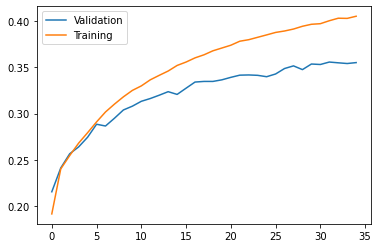

In [70]:
from matplotlib import pyplot as plt

epochs_ran = len(h.history['loss'])

plt.plot(range(0, epochs_ran), h.history['val_accuracy'], label='Validation')
plt.plot(range(0, epochs_ran), h.history['accuracy'], label='Training')
plt.legend()
plt.show()

Generate names

In [71]:
def generate_names(seed):
  for i in range(0, 40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding='pre',
                                                           maxlen=max_len-1,
                                                           truncating='pre')
    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break
  print(seed)

In [103]:
generate_names('H')

Harrior man	
